In [1]:
from yt.utilities.cosmology import Cosmology
import h5py
import shutil
import numpy as np
import os
import sys
import illustris_python as il
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
import pickle
import astropy.units as u
from astropy import wcs
from astropy.io import fits
from numbers import Number


basepaths = {'TNG100': ['/virgotng/universe/IllustrisTNG/TNG100-1/output',99],
              'SIMBA': ['/virgotng/universe/Simba/L100n1024FP/output',151],
              'EAGLE': ['/virgotng/universe/Eagle/Eagle100-1/output',28]  
            }

In [2]:
redshift= 0.025
h= 0.67
Omega_mass= 0.3089
Omega_lam= 0.6911
cosmo = Cosmology(h, Omega_mass, Omega_lam)

d_L = cosmo.luminosity_distance(0.0, redshift).to("cm").value
d_A = cosmo.angular_diameter_distance(0.0, redshift).to('kpc').value
area = 4* np.pi* d_L**2 
kpc_to_deg = (1/d_A)*(180/np.pi)

In [3]:
with open('/vera/ptmp/gc/madepa/data/xray_lum.pickle', 'rb') as f:
    lx_dict = pickle.load(f)
    
with open('/vera/ptmp/gc/madepa/data/masses.pickle', 'rb') as f:
    mass_dict = pickle.load(f)

# eROSITA

In [15]:
erosita_files = {'TNG100 HaloID 63':'../fits/no_background/eROSITA_TNG100_1200s/TNG100_halo_63_x_1200s_nb_ccd1_evt.fits',
                 'SIMBA HaloID 103':'../fits/no_background/eROSITA_SIMBA_1200s/SIMBA_halo_103_x_1200s_nb_ccd1_evt.fits',
                 'EAGLE HaloID 51':'../fits/no_background/eROSITA_EAGLE_1200s/EAGLE_halo_51_x_1200s_nb_ccd1_evt.fits'
                 }
r200 = []
r500 = []
r200.append(lx_dict['TNG100']['63']['R200c']*kpc_to_deg)
r500.append(lx_dict['TNG100']['63']['R500c']*kpc_to_deg)
r200.append(lx_dict['SIMBA']['103']['R200c']*kpc_to_deg)
r500.append(lx_dict['SIMBA']['103']['R500c']*kpc_to_deg)
r200.append(lx_dict['EAGLE']['51']['R200c']*kpc_to_deg)
r500.append(lx_dict['EAGLE']['51']['R500c']*kpc_to_deg)

M200 = []
M200.append(mass_dict['TNG100']['63']['M200c'])
M200.append(mass_dict['SIMBA']['103']['M200c'])
M200.append(mass_dict['EAGLE']['51']['M200c'])
print(M200)

[13.505142040556308, 13.538688466016, 13.518399411774062]


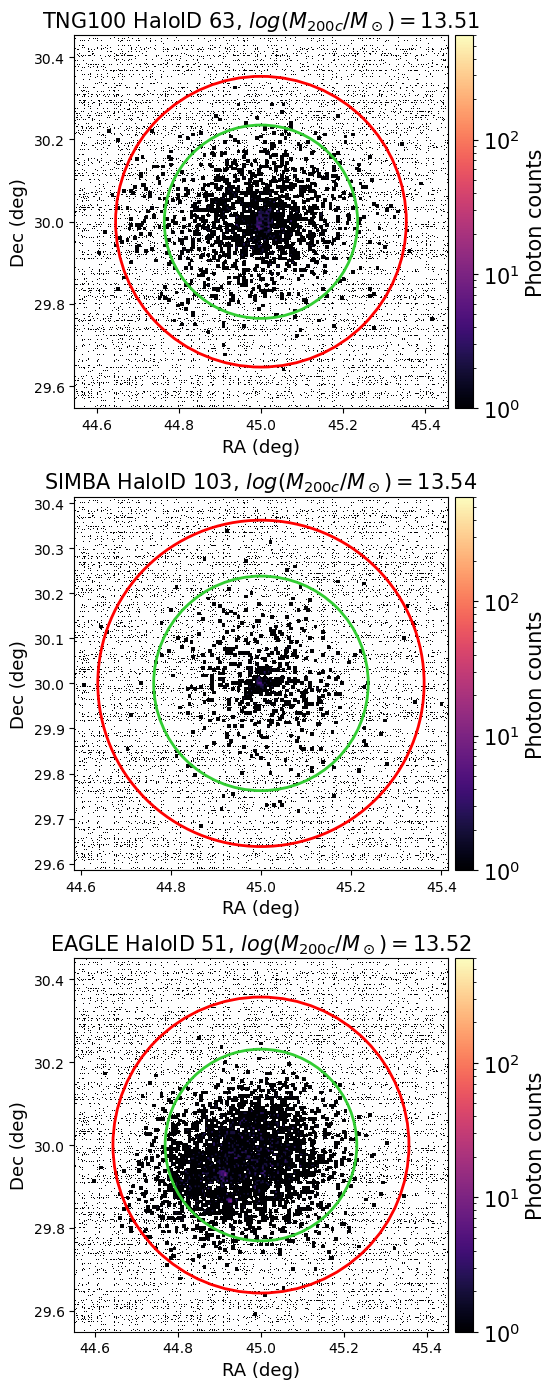

In [16]:
n_objects = len(erosita_files.keys())
fig, axs = plt.subplots(n_objects, 1, figsize=(8, 14)) 

for index, halo in enumerate(erosita_files.keys()):
    M200c = M200[index]
    r200c = r200[index]
    r500c = r500[index]

    # Plot eROSITA mock observation
    ra = np.array([])
    dec = np.array([])
    filename1 = erosita_files[halo][:-10]
    filename2 = erosita_files[halo][-9:]

    for i in [1, 2, 3, 4, 6]:
        with fits.open(f'{filename1}{i}{filename2}') as f:
            data = f[1].data
            mask = (data['SIGNAL']>0.5) & (data['SIGNAL']<2.0)
            ra = np.concatenate((ra, data['RA'][mask]))
            dec = np.concatenate((dec, data['DEC'][mask]))

    if r200c > max([(ra.max()-ra.min())/2, (dec.max()-dec.min())/2]):
        delta = r200c
    else:
        delta = max([(ra.max()-ra.min())/2, (dec.max()-dec.min())/2])
        
    xbins = np.linspace(45-delta,45+delta,200)
    ybins = np.linspace(30-delta,30+delta,200)
    hist, xedges, yedges = np.histogram2d(ra, dec, bins=(xbins, ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    im = axs[index].imshow(hist.T, extent=extent, cmap='magma', origin='lower', 
                           norm=LogNorm(vmin=1, vmax=600)) 
    cbar = fig.colorbar(im, ax=axs[index], label='Photon counts', fraction=0.046, pad=0.01) 
    cbar.set_label('Photon counts', fontsize=15)
    cbar.ax.tick_params(labelsize=15)

    axs[index].set_title(f'{halo},'+' $log(M_{200c}/M_\odot)=$'+f'{M200c:.2f}', fontsize=15)
    axs[index].set_xlabel('RA (deg)', fontsize=13)
    axs[index].set_ylabel('Dec (deg)', fontsize=13)
    axs[index].set_aspect('equal', 'box')

    # Add circles
    r1 = Circle((45, 30), r200c, color='red', fill=False, lw=2)
    r2 = Circle((45, 30), r500c, color='limegreen', fill=False, lw=2)
    axs[index].add_patch(r1)
    axs[index].add_patch(r2)
    #axs[index].set_xlim(45-r200c*1.1, 45+r200c*1.2)
    #axs[index].set_ylim(30-r200c*1.1, 30+r200c*1.2)

plt.tight_layout()
plt.savefig('../plots/erosita_2_mocks.pdf')

# XMM

In [29]:
xmm_files = {'TNG100 HaloID 22':'../fits/no_background/XMMfov_10ks/TNG100_halo_22_x_10ks_nb_evt.fits',
             'SIMBA HaloID 23':'../fits/no_background/XMMfov_10ks/SIMBA_halo_23_x_10ks_nb_evt.fits',
             'EAGLE HaloID 15':'../fits/no_background/XMMfov_10ks/EAGLE_halo_15_x_10ks_nb_evt.fits'
                }
r200 = []
r500 = []
r200.append(lx_dict['TNG100']['22']['R200c']*kpc_to_deg)
r500.append(lx_dict['TNG100']['22']['R500c']*kpc_to_deg)
r200.append(lx_dict['SIMBA']['23']['R200c']*kpc_to_deg)
r500.append(lx_dict['SIMBA']['23']['R500c']*kpc_to_deg)
r200.append(lx_dict['EAGLE']['15']['R200c']*kpc_to_deg)
r500.append(lx_dict['EAGLE']['15']['R500c']*kpc_to_deg)

M200 = []
M200.append(mass_dict['TNG100']['22']['M200c'])
M200.append(mass_dict['SIMBA']['23']['M200c'])
M200.append(mass_dict['EAGLE']['15']['M200c'])
print(M200)

[13.880200844117665, 13.898020830344175, 13.873258597509098]


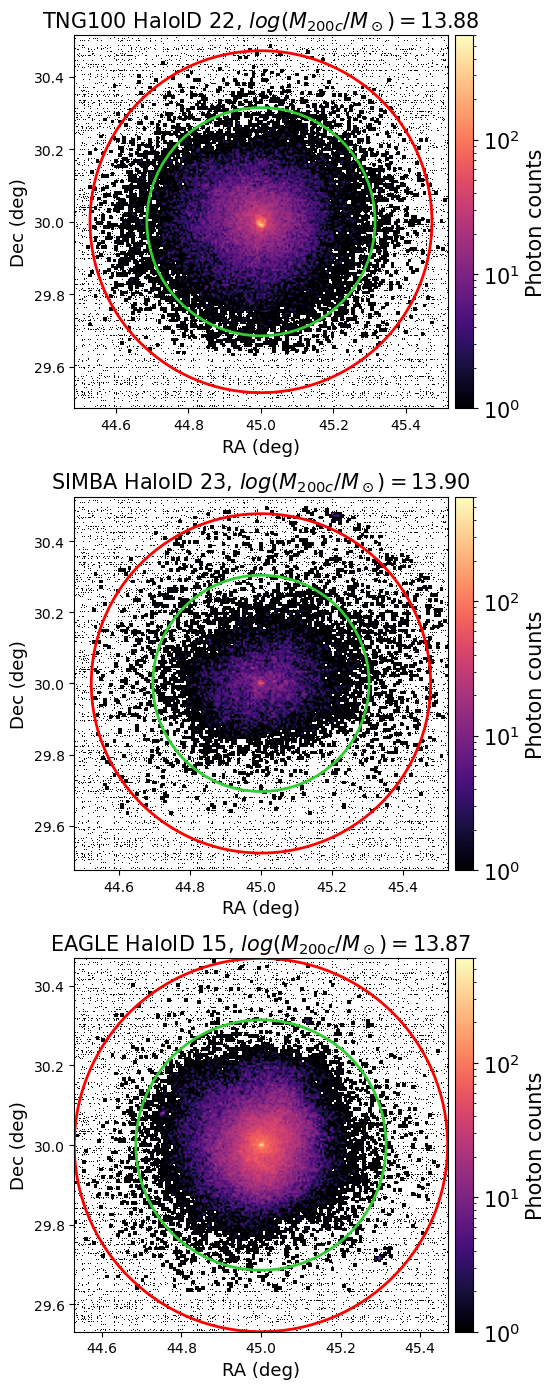

In [30]:
n_objects = len(xmm_files.keys())
fig, axs = plt.subplots(n_objects, 1, figsize=(8, 14)) 

for index, halo in enumerate(xmm_files.keys()):
    M200c = M200[index]
    r200c = r200[index]
    r500c = r500[index]
    # Plot Chandra mock observation
    file = fits.open(xmm_files[halo])
    data = file[1].data
    mask = (data['SIGNAL']>0.5) & (data['SIGNAL']<2.0)
    ra = data['RA'][mask]
    dec = data['DEC'][mask]

    if r200[index] > max([(ra.max()-ra.min())/2, (dec.max()-dec.min())/2]):
        delta = r200[index]
    else:
        delta = max([(ra.max()-ra.min())/2, (dec.max()-dec.min())/2])
        
    xbins = np.linspace(45-delta,45+delta,200)
    ybins = np.linspace(30-delta,30+delta,200)
    hist, xedges, yedges = np.histogram2d(ra, dec, bins=(xbins, ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    im = axs[index].imshow(hist.T, extent=extent, cmap='magma', origin='lower', 
                           norm=LogNorm(vmin=1, vmax=600)) 
    cbar = fig.colorbar(im, ax=axs[index], label='Photon counts', fraction=0.046, pad=0.01) 
    cbar.set_label('Photon counts', fontsize=15)
    cbar.ax.tick_params(labelsize=15)

    axs[index].set_title(f'{halo},'+' $log(M_{200c}/M_\odot)=$'+f'{M200c:.2f}', fontsize=15)
    axs[index].set_xlabel('RA (deg)', fontsize=13)
    axs[index].set_ylabel('Dec (deg)', fontsize=13)
    axs[index].set_aspect('equal', 'box')

    # Add circles
    r1 = Circle((45, 30), r200c, color='red', fill=False, lw=2)
    r2 = Circle((45, 30), r500c, color='limegreen', fill=False, lw=2)
    axs[index].add_patch(r1)
    axs[index].add_patch(r2)

plt.tight_layout()
plt.savefig('../plots/xmm_1_mocks.pdf')

# Chandra

In [24]:
chandra_files = {'TNG100 HaloID 63':'../fits/no_background/Chandra/TNG100_halo_63_x_100ks_nb_evt.fits',
                 'SIMBA HaloID 103':'../fits/no_background/Chandra/SIMBA_halo_103_x_100ks_nb_evt.fits',
                 'EAGLE HaloID 51':'../fits/no_background/Chandra/EAGLE_halo_51_x_100ks_nb_evt.fits'
                }
r200 = []
r500 = []
r200.append(lx_dict['TNG100']['63']['R200c']*kpc_to_deg)
r500.append(lx_dict['TNG100']['63']['R500c']*kpc_to_deg)
r200.append(lx_dict['SIMBA']['103']['R200c']*kpc_to_deg)
r500.append(lx_dict['SIMBA']['103']['R500c']*kpc_to_deg)
r200.append(lx_dict['EAGLE']['51']['R200c']*kpc_to_deg)
r500.append(lx_dict['EAGLE']['51']['R500c']*kpc_to_deg)

M200 = []
M200.append(mass_dict['TNG100']['63']['M200c'])
M200.append(mass_dict['SIMBA']['103']['M200c'])
M200.append(mass_dict['EAGLE']['51']['M200c'])
print(M200)

[13.505142040556308, 13.538688466016, 13.518399411774062]


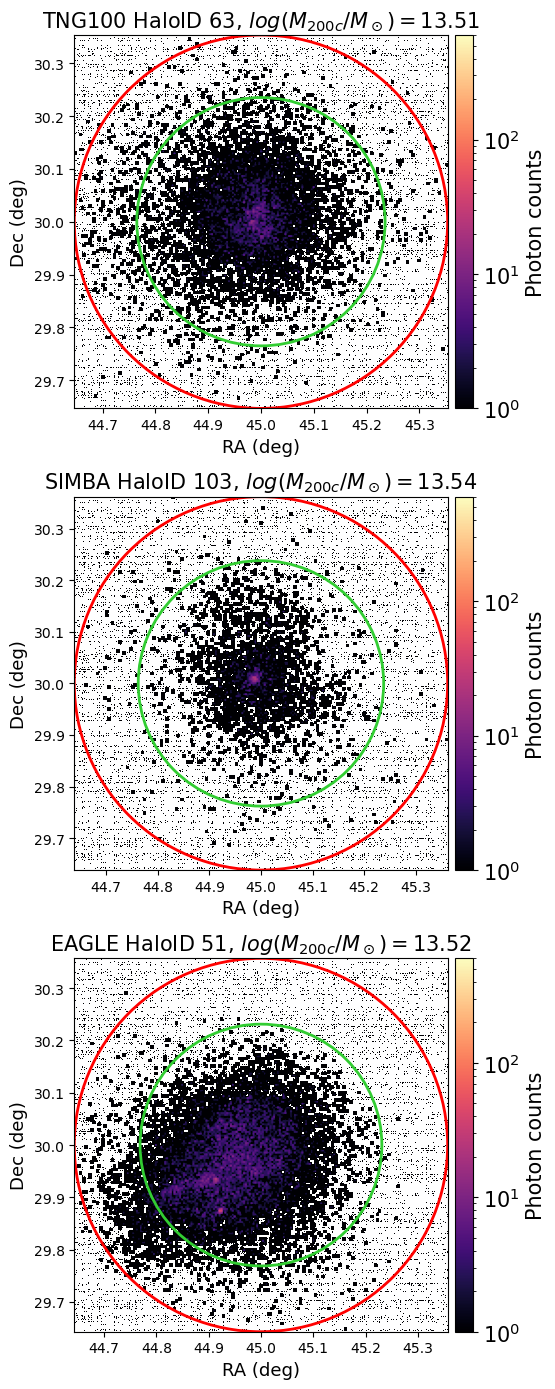

In [23]:
n_objects = len(chandra_files.keys())
fig, axs = plt.subplots(n_objects, 1, figsize=(8, 14)) 

for index, halo in enumerate(chandra_files.keys()):
    M200c = M200[index]
    r200c = r200[index]
    r500c = r500[index]
    # Plot Chandra mock observation
    file = fits.open(chandra_files[halo])
    data = file[1].data
    mask = (data['ENERGY']>500) & (data['ENERGY']<2000)
    ra = -data['DETX'][mask]*0.492/3600 +45
    dec = data['DETY'][mask]*0.492/3600 +30

    if r200[index] > max([(ra.max()-ra.min())/2, (dec.max()-dec.min())/2]):
        delta = r200[index]
    else:
        delta = max([(ra.max()-ra.min())/2, (dec.max()-dec.min())/2])
        
    xbins = np.linspace(45-delta,45+delta,200)
    ybins = np.linspace(30-delta,30+delta,200)
    hist, xedges, yedges = np.histogram2d(ra, dec, bins=(xbins, ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    im = axs[index].imshow(hist.T, extent=extent, cmap='magma', origin='lower', 
                           norm=LogNorm(vmin=1, vmax=600)) 
    cbar = fig.colorbar(im, ax=axs[index], label='Photon counts', fraction=0.046, pad=0.01) 
    cbar.set_label('Photon counts', fontsize=15)
    cbar.ax.tick_params(labelsize=15)

    axs[index].set_title(f'{halo},'+' $log(M_{200c}/M_\odot)=$'+f'{M200c:.2f}', fontsize=15)
    axs[index].set_xlabel('RA (deg)', fontsize=13)
    axs[index].set_ylabel('Dec (deg)', fontsize=13)
    axs[index].set_aspect('equal', 'box')

    # Add circles
    r1 = Circle((45, 30), r200c, color='red', fill=False, lw=2)
    r2 = Circle((45, 30), r500c, color='limegreen', fill=False, lw=2)
    axs[index].add_patch(r1)
    axs[index].add_patch(r2)

plt.tight_layout()
plt.savefig('../plots/chandra_2_mocks.pdf')